In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 777

# Categorical nuisance

In [38]:
from carl.distributions import Mixture, MultivariateNormal

p = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
q0 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([1., 1.5]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([1., 4.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [39]:
from keras.utils import np_utils

n_samples = 50000
n_samples //= (2 * 3)

X0 = np.vstack([p.rvs(n_samples), 
                q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), 
                q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), 
                q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])

z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2
z = np_utils.to_categorical(z.astype(np.int))

In [40]:
X.shape, y.shape, z.shape

((49998, 2), (49998,), (49998, 3))

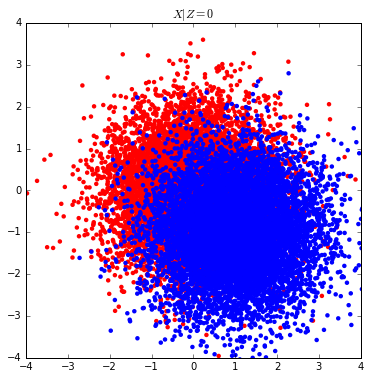

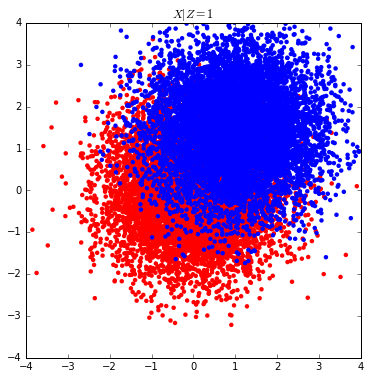

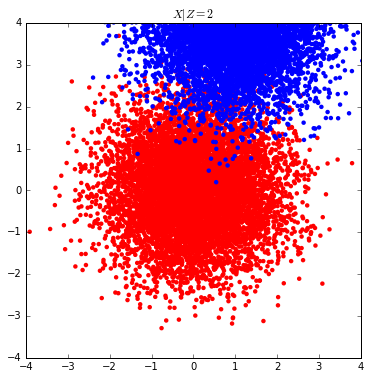

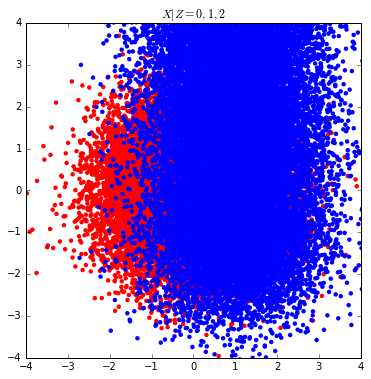

In [41]:
plt.title("$X|Z=0$")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=1$")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=2$")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=0,1,2$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [42]:
from scipy.stats import entropy

# when Z is marginalized out, the best classifier is p.pdf(X) / (p.pdf(X) + q_full.pdf(X)

probas = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
probas = np.hstack([probas.reshape(-1, 1), 
                    (1.-probas).reshape(-1, 1)])
min_Lf = np.mean([entropy(p_i) for p_i in probas])   # lower bound on Lf
min_Lr = entropy([1. / 3] * 3)

In [43]:
min_Lf, min_Lr

(0.43276536363305629, 1.0986122886681096)

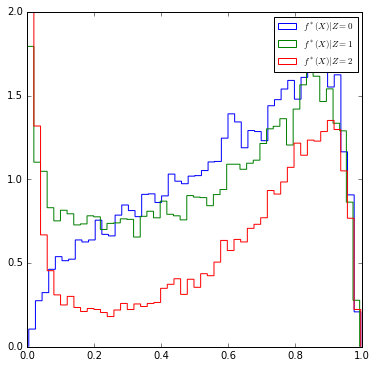

In [44]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0$", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=1$", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=2$", normed=1)
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0, 2.)
plt.show()

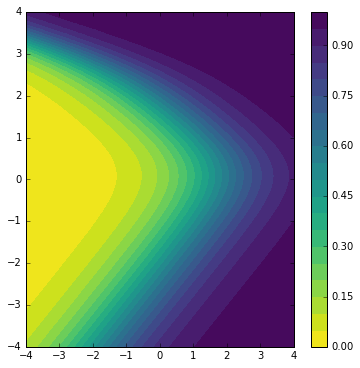

In [45]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

xi = np.linspace(-4, 4., 100)
yi = np.linspace(-4, 4., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [46]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y1, q_full.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.7768985474407577,
 0.84393312369960294,
 0.99582604209004544,
 0.87157224118477927)

# Adversarial training of f

In [66]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [67]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(20, activation="tanh")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [68]:
R.predict(X_train[:3])

array([[ 0.28644255,  0.32476428,  0.38879317],
       [ 0.26809943,  0.31976771,  0.41213289],
       [ 0.25994053,  0.31721053,  0.42284894]], dtype=float32)

In [69]:
from keras.optimizers import Adam, SGD
import keras.backend as K

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD() #Adam() #SGD(lr=10e-3, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD() # Adam() #SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [70]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_9 (Model)                  (None, 1)             501         input_3[0][0]                    
____________________________________________________________________________________________________
model_10 (Model)                 (None, 3)             1024        input_3[0][0]                    
Total params: 1525
____________________________________________________________________________________________________


In [71]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_10 (Model)                 (None, 3)             1024        input_3[0][0]                    
Total params: 1024
____________________________________________________________________________________________________


In [72]:
DRf.predict(X_train[:3])

[array([[ 0.29861483],
        [ 0.42252669],
        [ 0.4795756 ]], dtype=float32),
 array([[ 0.28644255,  0.32476428,  0.38879317],
        [ 0.26809943,  0.31976771,  0.41213289],
        [ 0.25994053,  0.31721053,  0.42284894]], dtype=float32)]

In [73]:
DfR.predict(X_train[:3])

array([[ 0.28644255,  0.32476428,  0.38879317],
       [ 0.26809943,  0.31976771,  0.41213289],
       [ 0.25994053,  0.31721053,  0.42284894]], dtype=float32)

In [74]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 0.4967     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 0.4428     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 0.4404     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 0.4395     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 0.4389     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.4384     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.4380     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.4377     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.4374     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.4372     


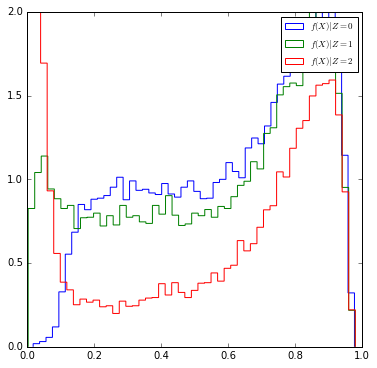

In [75]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0, 2.)
plt.show()

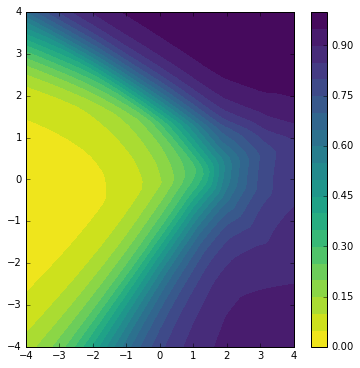

In [76]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

xi = np.linspace(-4., 4., 100)
yi = np.linspace(-4., 4., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [77]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 1.0543     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 1.0202     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 0.9952     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 0.9775     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 0.9651     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.9569     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.9513     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.9473     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.9441     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.9418     


In [78]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right", prop={'size': 9})
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right", prop={'size': 9}, ncol=2)
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right", prop={'size': 9})
    
    plt.show()   

In [79]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

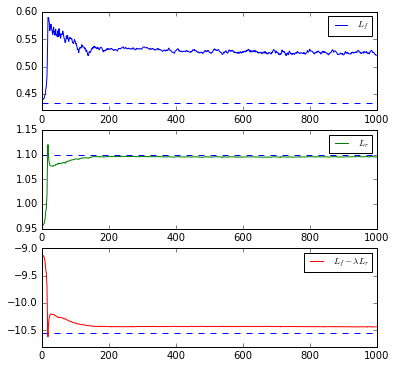

In [80]:
batch_size = 128

for i in range(1001):
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

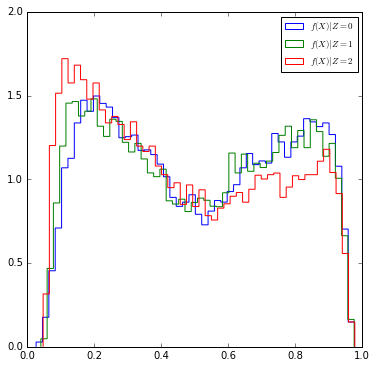

In [81]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0, 2.)
plt.show()

Looks pivotal!

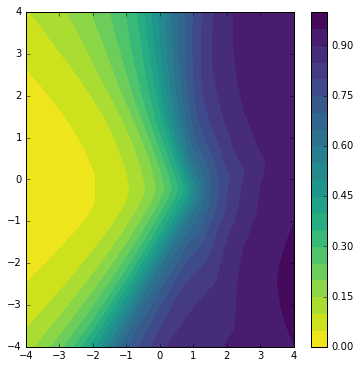

In [82]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

xi = np.linspace(-4., 4., 100)
yi = np.linspace(-4., 4., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [83]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.78533045077953356,
 0.80078624961871159,
 0.86515335088382528,
 0.81693292612699753)

In [84]:
print(min_Lr)

probas = DfR.predict(X_valid)
mean_entropy_f = np.mean([entropy(q) for q in probas])
print(mean_entropy_f)

1.09861228867
1.09586


---

# Continuous nuisance

In [85]:
from carl.distributions import Mixture, MultivariateNormal, Uniform

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
p1 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
pz = Uniform(low=-1.0, high=4.0)

In [86]:
n_samples = 50000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

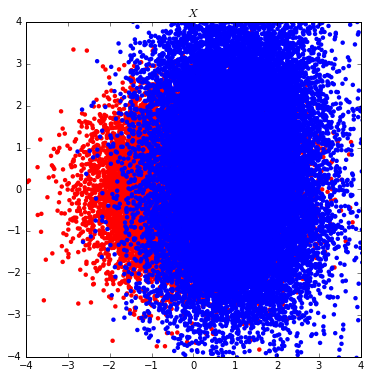

In [87]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

# Adversarial training of f

In [88]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [89]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

# XXX: switch for a mixture density network
# http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.7-MixDensityNetworks.pdf
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(1, activation="tanh")(Rx)  
mu = Lambda(lambda x: 2.5*x+1.5)(mu)    
sigma = Dense(1, activation="tanh")(Rx)
sigma = Lambda(lambda x: (1.001 + x) * 5.)(sigma)
Rx = Merge(mode="concat")([mu, sigma])

R = Model(input=[inputs], output=[Rx])

In [90]:
R.predict(X_train[:3])

array([[ 1.43653882,  4.7700634 ],
       [ 1.44797277,  4.81235933],
       [ 1.42945766,  4.74388075]], dtype=float32)

In [91]:
from keras.optimizers import Adam, SGD
import keras.backend as K
import theano.tensor as T

lam = 20.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        a = -1.0
        b = 4.0
        
        z = z_true.ravel()
        mu = z_pred[:, 0].ravel() 
        sigma = z_pred[:, 1].ravel() 
        
        ll = (-K.log(sigma) 
              -np.log(np.sqrt(2. * np.pi)) 
              -((z - mu) ** 2 / (2. * sigma ** 2))
              +np.log(2.)
              -K.log(T.erf((b - mu) / (sigma * np.sqrt(2.))) - 
                     T.erf((a - mu) / (sigma * np.sqrt(2.)))))
        
        return -c * ll.mean()
    
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = Adam() # SGD() # Adam()
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = Adam() # SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [92]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_13 (Model)                 (None, 1)             501         input_4[0][0]                    
____________________________________________________________________________________________________
model_14 (Model)                 (None, 2)             1423        input_4[0][0]                    
Total params: 1924
____________________________________________________________________________________________________


In [93]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_14 (Model)                 (None, 2)             1423        input_4[0][0]                    
Total params: 1423
____________________________________________________________________________________________________


In [94]:
DRf.predict(X_train[:3])

[array([[ 0.44753659],
        [ 0.3668775 ],
        [ 0.49749902]], dtype=float32), array([[ 1.43653882,  4.7700634 ],
        [ 1.44797277,  4.81235933],
        [ 1.42945766,  4.74388075]], dtype=float32)]

In [95]:
DfR.predict(X_train[:3])

array([[ 1.43653882,  4.7700634 ],
       [ 1.44797277,  4.81235933],
       [ 1.42945766,  4.74388075]], dtype=float32)

In [96]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)

Epoch 1/10
45000/45000 [==============================] - 0s - loss: 0.5703     
Epoch 2/10
45000/45000 [==============================] - 0s - loss: 0.5280     
Epoch 3/10
45000/45000 [==============================] - 0s - loss: 0.5225     
Epoch 4/10
45000/45000 [==============================] - 0s - loss: 0.5212     
Epoch 5/10
45000/45000 [==============================] - 0s - loss: 0.5205     
Epoch 6/10
45000/45000 [==============================] - 0s - loss: 0.5198     
Epoch 7/10
45000/45000 [==============================] - 0s - loss: 0.5193     
Epoch 8/10
45000/45000 [==============================] - 0s - loss: 0.5188     
Epoch 9/10
45000/45000 [==============================] - 0s - loss: 0.5184     
Epoch 10/10
45000/45000 [==============================] - 0s - loss: 0.5180     


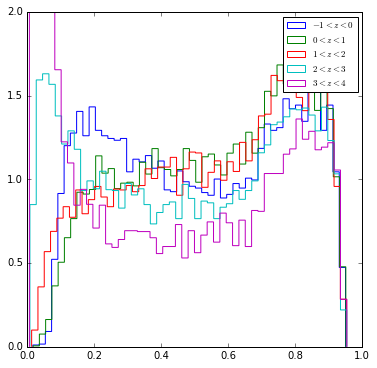

In [97]:
plt.hist(1. - D.predict(X[(-1 < z) & (z < 0)]), bins=50, normed=1, histtype="step", label="$-1<z<0$")
plt.hist(1. - D.predict(X[(0 < z) & (z < 1)]), bins=50, normed=1, histtype="step", label="$0<z<1$")
plt.hist(1. - D.predict(X[(1 < z) & (z < 2)]), bins=50, normed=1, histtype="step", label="$1<z<2$")
plt.hist(1. - D.predict(X[(2 < z) & (z < 3)]), bins=50, normed=1, histtype="step", label="$2<z<3$")
plt.hist(1. - D.predict(X[(3 < z) & (z < 4)]), bins=50, normed=1, histtype="step", label="$3<z<4$")
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0,2)
plt.show()

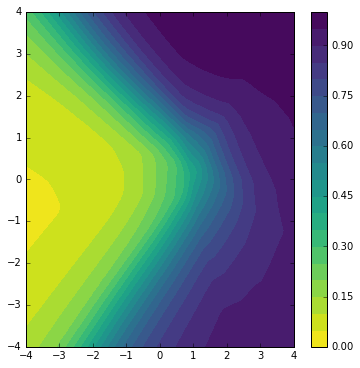

In [98]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-4., 4., 100)
yi = np.linspace(-4., 4., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [99]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=20)

Epoch 1/20
45000/45000 [==============================] - 0s - loss: 1.5866     
Epoch 2/20
45000/45000 [==============================] - 0s - loss: 1.5511     
Epoch 3/20
45000/45000 [==============================] - 0s - loss: 1.5458     
Epoch 4/20
45000/45000 [==============================] - 0s - loss: 1.5441     
Epoch 5/20
45000/45000 [==============================] - 0s - loss: 1.5432     
Epoch 6/20
45000/45000 [==============================] - 0s - loss: 1.5425     
Epoch 7/20
45000/45000 [==============================] - 0s - loss: 1.5419     
Epoch 8/20
45000/45000 [==============================] - 0s - loss: 1.5417     
Epoch 9/20
45000/45000 [==============================] - 0s - loss: 1.5416     
Epoch 10/20
45000/45000 [==============================] - 0s - loss: 1.5415     
Epoch 11/20
45000/45000 [==============================] - 0s - loss: 1.5415     
Epoch 12/20
45000/45000 [==============================] - 0s - loss: 1.5415     
Epoch 13/20
45000/45000 [

In [100]:
DfR.predict(X_train[:10])

array([[ 3.9258182 ,  2.85657859],
       [-0.31284323,  4.43138456],
       [ 0.61782181,  2.81340718],
       [ 0.72148037,  2.85506916],
       [ 3.87513375,  3.13013053],
       [ 0.73035192,  2.85859394],
       [ 0.80647087,  5.63978291],
       [ 0.56107002,  2.81338573],
       [ 0.66707265,  2.83331656],
       [ 0.52672881,  2.82985497]], dtype=float32)

In [101]:
from IPython import display

min_Lr = np.log(5.0)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right", prop={'size': 9})
    
    ax2 = plt.subplot(312, sharex=ax1)  
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right", prop={'size': 9})
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right", prop={'size': 9})
    
    plt.show()   

In [102]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

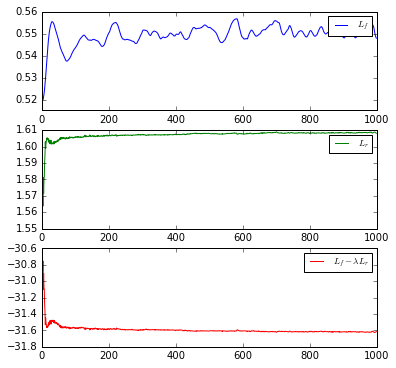

In [103]:
batch_size = 128

for i in range(1001):
    if i % 5 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
#     for j in range(100):
#         indices = np.random.permutation(len(X_train))[:batch_size]
#         DfR.train_on_batch(X_train[indices], z_train[indices])
    DfR.fit(X_train, z_train, nb_epoch=1, verbose=0)

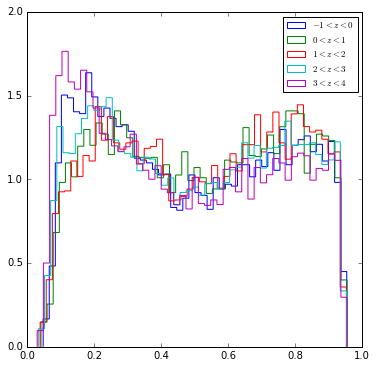

In [104]:
#plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="$-1<z<4$")
plt.hist(1. - D.predict(X[(-1 < z) & (z < 0)]), bins=50, normed=1, histtype="step", label="$-1<z<0$")
plt.hist(1. - D.predict(X[(0 < z) & (z < 1)]), bins=50, normed=1, histtype="step", label="$0<z<1$")
plt.hist(1. - D.predict(X[(1 < z) & (z < 2)]), bins=50, normed=1, histtype="step", label="$1<z<2$")
plt.hist(1. - D.predict(X[(2 < z) & (z < 3)]), bins=50, normed=1, histtype="step", label="$2<z<3$")
plt.hist(1. - D.predict(X[(3 < z) & (z < 4)]), bins=50, normed=1, histtype="step", label="$3<z<4$")
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0,2)
plt.show()

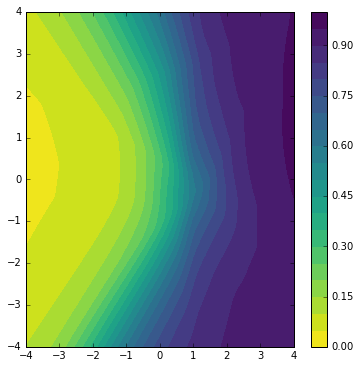

In [105]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-4., 4., 100)
yi = np.linspace(-4., 4., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 